## Análisis preliminar de datos

A continuación se presenta un primer análisis basado en los datos del Censo INE 2011, publicados en la página web del Instituto.

Además se utilizan varios conjuntos de datos disponibilizados en la web. Se realizó un pre-procesamiento para seleccionar variables relevantes, reduciendo el volúmen de datos y por tanto los requerimientos informáticos para su acceso.

Como capas de información geográfica se se cuenta la capas de polígonos de departamento y de puntos de localidades del INE, identificando las capitales departamentales en esta última capa.

Se incluye una matriz de distancias entre cada centro medio de población, calculada con la API Google Distance Matrix, que consta de distancias a pie por la red de caminería entre el centro medio de población de cada departamento, obteniendo una matriz con 342 valores ((19x19)-19).

Se prefirió usar el centro medio de población, en detrimento del centroide o la capital departamental. El centro medio de población se calcula transfiriendo el conteo de habitantes del segmento censal al centroide de dicho segmento, aplicando luego la siguiente fórmula:

$$
\overline{X}_w=\frac{\sum_{i=1}^{n}w_{i}X_{i}}{\sum_{i=1}^{n} w_{i}}
$$


$$
\overline{Y}_w=\frac{\sum_{i=1}^{n}w_{i}Y_{i}}{\sum_{i=1}^{n} w_{i}}
$$

dónde

$$w = peso$$

En este caso el "peso" (w) sería la población, en tanto que "x" e "y" son las coordenadas cartográficas de cada centroide.

De esta forma se obtiene un par de coordenadas para cada departamento, que representa ese centro medio.

El PBI departamental de toma de la información producida y publicada por OPP **(cita).**

In [ ]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabulate

from shapely import wkt
from shapely.geometry import shape, LineString, Point
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [2]:
# carga datos

# Datos censales
censo = pd.read_csv('tablas/personas_censo_2011.zip', compression='zip', header=0, sep=',', quotechar='"')

# PBI departamental
pbi = pd.read_csv('tablas/pbi_departamental.csv')

# matriz de distancias
md = pd.read_csv('tablas/df_distancias_centro_poblacion.csv')
md.drop(['latlon_ori', 'latlon_des'], axis=1, inplace=True)

# carga capa departamentos INE pg
deptos = gpd.read_file('capas/ine_deptos.gpkg')

# agrega centroides de departamentos
deptos['centroide'] = deptos['geometry'].centroid

# carga capa localidades INE pt
localidad = gpd.read_file('capas/ine_localidades.gpkg')
localidad.CODLOC = localidad.CODLOC.astype(int)

# centro de población
centro_pobl = gpd.read_file('capas/centro_poblacion.gpkg')

# filtra capitales departamentales de las localidades INE
capital = localidad[localidad.CAPITAL==True].reset_index(drop=True)

In [113]:
# calcula la población de cada departamento
poblacion = censo[['DPTO', 'LOC']].groupby(by=['DPTO']).count()
poblacion.rename(columns={'LOC': 'poblacion'}, inplace=True)

# genera dataframe con datos por departamento
datos_dpto = pd.merge(pbi, poblacion, on='DPTO')

datos_dpto.head()

,DPTO,NOMBRE,miles_de_pesos,porcentaje_pbi,poblacion
0,2,ARTIGAS,14214980,"1,5",73377
1,3,CANELONES,86306492,"9,3",520173
2,4,CERRO LARGO,17048887,"1,8",84698
3,5,COLONIA,43788749,"4,7",123203
4,6,DURAZNO,13023942,"1,4",57084


**Análisis por departamentos**

Dada la menor complejidad, se comienza por el análisis de los flujos entre departamentos.
La base de personas del Censo INE 2011 se filtra según el siguiente criterio:
- Variable "PERMI07" (lugar de residencia 5 años antes) con valores:
    - 2 = en otra localidad o paraje de este departamento
    - 3 = en otro departamento
    
Se excluyen habitantes de localidades rurales.

La tabla resultante contiene un departamento de origen, uno de destino y una cantidad de personas que declaran haber vivido antes en el departamento de "origen", habiendo sido relevadas en el departamento de "destino" al momento de la aplicación del formulario censal.

In [114]:
# define columnas para filtrar
cols = ['DPTO', 'LOC', 'SECC', 'SEGM', 'PERMI07', 'PERMI07_1',
        'PERMI07_2', 'PERMI07_3', 'PERMI07_4']

# filtra
p_migr = censo.loc[(censo.PERMI07 == 2) | (censo.PERMI07 == 3), cols]

# cambia DPTO a tipo entero
p_migr.DPTO = p_migr.DPTO.astype(int)

# print(p_migr.shape[0])

# Hay 26.449 residentes en localidades rurales
# print(p_migr[( p_migr.LOC == 900 )].shape[0])

# identifica depto de residencia anterior, rellena NAs y convierte a tipo INT
p_migr['depto_origen'] = p_migr.loc[:,('PERMI07_2')].fillna(p_migr.DPTO).astype(int)

# renombra DPTO
p_migr.rename(columns={'DPTO': 'depto_destino'}, inplace=True)

p_migr.head()

,depto_destino,LOC,SECC,SEGM,PERMI07,PERMI07_1,PERMI07_2,PERMI07_3,PERMI07_4,depto_origen
5,1,20,1,1,3,NaN,3.0,732.0,0,3
40,1,20,1,1,3,NaN,17.0,220.0,0,17
50,1,20,1,1,3,NaN,18.0,220.0,0,18
64,1,20,1,1,3,NaN,2.0,220.0,0,2
110,1,20,1,1,3,NaN,12.0,320.0,0,12


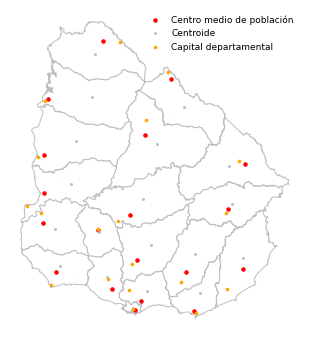

In [115]:
# plot de las capas de departamentos y localidades
f, ax = plt.subplots(1,figsize=(8,6))

# apaga ejes
plt.axis('off')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# deptos
deptos.plot(color='w', edgecolor='silver',ax=ax)

# localidades
centro_pobl.plot(markersize=12, color = 'red', ax = ax, label='Centro medio de población')
deptos.geometry.centroid.plot(markersize=4, color = 'silver', ax = ax, label='Centroide')
capital.plot(markersize=7, color = 'orange', ax = ax, label='Capital departamental')

# referencias
plt.legend(fontsize=9, frameon=False)

metadatos_figs = {'Author': '''Guillermo D'Angelo''', 'Title': 'Mapa Centro de Población'}

plt.savefig('mapas_graficas/centro_poblacion.pdf', bbox_inches='tight',
            metadata = metadatos_figs )

In [116]:
p_migr

,depto_destino,LOC,SECC,SEGM,PERMI07,PERMI07_1,PERMI07_2,PERMI07_3,PERMI07_4,depto_origen
5,1,20,1,1,3,NaN,3.0,732.0,0,3
40,1,20,1,1,3,NaN,17.0,220.0,0,17
50,1,20,1,1,3,NaN,18.0,220.0,0,18
64,1,20,1,1,3,NaN,2.0,220.0,0,2
110,1,20,1,1,3,NaN,12.0,320.0,0,12
...,...,...,...,...,...,...,...,...,...,...
3285865,19,967,3,604,2,220.0,NaN,NaN,0,19
3285866,19,968,2,407,3,NaN,14.0,621.0,0,14
3285867,19,968,2,407,3,NaN,13.0,822.0,0,13
3285874,19,971,3,404,3,NaN,14.0,942.0,0,14


In [117]:
# genera un sólo dataframe solo para deptos
cols= ['depto_origen', 'depto_destino']
flujos_deptos = p_migr.loc[p_migr.depto_origen != p_migr.depto_destino, cols].reset_index(drop=True)

# agrupa y cuenta
grupo = flujos_deptos.groupby(by=['depto_origen', 'depto_destino']).size().to_frame('personas_mig')

print('Cantidad de díadas ', grupo.shape[0])

grupo.head()

Cantidad de díadas  342


personas_mig
depto_origen depto_destino              
1            2                       914
             3                     33127
             4                      1387
             5                      2100
             6                       982

In [118]:
print(grupo.reset_index().head().to_markdown(showindex=False))

|   depto_origen |   depto_destino |   personas_mig |
|---------------:|----------------:|---------------:|
|              1 |               2 |            914 |
|              1 |               3 |          33127 |
|              1 |               4 |           1387 |
|              1 |               5 |           2100 |
|              1 |               6 |            982 |


A continuación se presentan dichos datos en formato de matriz simétrica, refiriéndose a cada departamento con su código INE.

In [119]:
# genera tabla pivot con los flujos de departamento a departamento
matrix = pd.pivot_table(flujos_deptos,
                        index =  'depto_origen',
                        columns= 'depto_destino',
                        fill_value=0,
                        aggfunc=len,
                        margins=True,
                        margins_name='Total')
matrix

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Total
depto_origen,,,,,,,,,,,,,,,,,,,,
1,0,914,33127,1387,2100,982,378,1026,825,3914,1075,886,1665,1266,1547,4209,1173,1421,760,58655
2,2395,0,536,20,167,33,21,40,15,472,200,57,146,47,794,92,24,100,5,5164
3,11162,74,0,274,422,223,82,670,403,1345,148,154,320,360,159,908,154,251,124,17233
4,1805,15,435,0,63,67,5,73,131,810,61,41,145,95,19,49,34,135,476,4459
5,2690,28,366,20,0,63,69,53,19,309,71,88,34,35,68,269,513,34,23,4752
6,1610,32,466,64,70,0,149,404,67,198,59,62,42,61,28,124,32,212,77,3757
7,735,2,162,13,86,90,0,76,5,79,30,36,10,13,17,116,85,29,14,1598
8,1420,13,892,37,107,307,84,0,163,310,47,30,46,62,19,321,51,68,64,4041
9,1264,7,446,64,39,29,17,138,0,936,28,11,25,150,15,45,11,45,221,3491


In [120]:
# lista de nombres deptos para generar tabla en latex
nomdep = ['Mvdeo.', 'Artigas', 'Can.', 'C. Largo', 'Colonia', 'Durazno',
          'Flores', 'Florida', 'Lavalleja','Maldonado', 'Paysandú', 'R. Negro', 'Rivera',
          'Rocha', 'Salto', 'San José', 'Soriano', 'Tacuarembó', 'T. y Tres']

coddep = np.arange(1, 20, 1).tolist()

# guarda tabla en latex
# cabecera = datos_dpto.sort_values('DPTO')['NOMBRE'].to_list()
# cabecera.append('Total')

matrix_tex = matrix
matrix_tex.rename(index=dict(zip(coddep, nomdep)), inplace=True)

# setea ancho de columnas
ancho = 'p{0.7cm}'
colformato='l' + ancho * 20

matrix_tex.to_latex(buf= "tablas/matriz_orig_dest.tex", bold_rows=False,
                    column_format = colformato,
                    caption= 'Matriz de movimientos entre departamentos (Censo INE 2011).')

Se contruye un conjunto de datos que contiene la siguiente información para cada díada de departamentos:
- Los datos son los totales de personas que declaran haber vivido antes en el departamento de origen
- La población total en origen y destino
- El PBI en el departamento de destino y el logaritmo de dicho valor
- La distancia entre cada centro medio de población y el logaritmo de dicho valor

In [121]:
# unimos todo en un dataframe de díadas
df_agrupado = grupo.reset_index()

# agrega codigo único
df_agrupado.insert(0, 'cod', (df_agrupado['depto_origen'].astype(str)
                   + df_agrupado['depto_destino'].astype(str).str.zfill(2)).astype(int))

# recupera datos de otros dataframes
cols = ['DPTO', 'NOMBRE', 'miles_de_pesos', 'poblacion']
merge1 = pd.merge(df_agrupado, datos_dpto[cols],left_on='depto_origen', right_on='DPTO')
merge2 = pd.merge(merge1, datos_dpto[cols], left_on='depto_destino', right_on='DPTO')
merge3 = pd.merge(merge2, md[['cod', 'distancia']], on='cod')
datos_diadas = merge3.drop(['DPTO_x', 'DPTO_y'], axis=1)

# borra productos intermedios
del(merge1, merge2, merge3)

# renombra columnas
dict_rename = {'NOMBRE_x': 'nom_depto_orig', 'NOMBRE_y': 'nom_depto_des',
               'miles_de_pesos_x': 'pbi_origen', 'miles_de_pesos_y': 'pbi_destino',
               'distancia': 'dist', 'poblacion_x': 'pob_origen',
               'poblacion_y': 'pob_destino'}

datos_diadas.rename(columns=dict_rename, inplace=True)

# incorporamos el logaritmo del PBI departamental en destino
datos_diadas = datos_diadas.assign(log_pbi_destino = lambda x: np.log(x['pbi_destino']))

# incorporamos el logaritmo de las distancias entre díadas
datos_diadas = datos_diadas.assign(log_dist = lambda x: np.log(x['dist']))

# reordena variables
order = ['cod', 'depto_origen', 'nom_depto_orig',
         'depto_destino', 'nom_depto_des', 'personas_mig',
         'pbi_origen', 'pob_origen', 'pbi_destino', 'pob_destino',
         'dist', 'log_pbi_destino', 'log_dist']

datos_diadas = datos_diadas[order]
datos_diadas.head()

,cod,depto_origen,nom_depto_orig,depto_destino,nom_depto_des,personas_mig,pbi_origen,pob_origen,pbi_destino,pob_destino,dist,log_pbi_destino,log_dist
0,102,1,MONTEVIDEO,2,ARTIGAS,914,465848031,1318755,14214980,73377,610726,16.469807,13.322404
1,302,3,CANELONES,2,ARTIGAS,74,86306492,520173,14214980,73377,601915,16.469807,13.307872
2,402,4,CERRO LARGO,2,ARTIGAS,15,17048887,84698,14214980,73377,406694,16.469807,12.915816
3,502,5,COLONIA,2,ARTIGAS,28,43788749,123203,14214980,73377,556292,16.469807,13.229049
4,602,6,DURAZNO,2,ARTIGAS,32,13023942,57084,14214980,73377,446123,16.469807,13.008350


In [122]:
# guarda
datos_diadas.to_csv('tablas/datos_diadas_2011.csv')

In [123]:
# define función para hacer lineas a partir de códigos origen-destino y una geografía conocida
# fuente: https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Unconstrained%20Spatial%20Interaction%20Models.ipynb

def _odline(orig, dest, geo, zonecode):
    return LineString([deptos[geo[zonecode] == orig].centroid.values[0], geo[geo[zonecode] == dest].centroid.values[0]])

# Makes a geodataframe of flows
def odflow(flowdata, origin, destination, flow_value, geo, zonecode):
    # First make all the lines
    lines = flowdata.apply(lambda x: _odline(x[origin], x[destination], geo, zonecode), axis=1)
    # Now get the series of flow values
    flows = flowdata[[flow_value, origin, destination]]
    # Now return a geodataframe
    return gpd.GeoDataFrame(flows, geometry=lines, crs = geo.crs)

# aplica función
flows = odflow(datos_diadas,'depto_origen', 'depto_destino', 'personas_mig', deptos,'cod_ine')

# guarda como geopaquete
flows.to_file("capas/mig_recientes_2011.gpkg", layer='flujos', driver="GPKG")

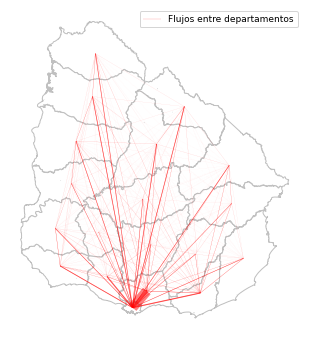

In [124]:
# plot de flujos
f, ax = plt.subplots(1,figsize=(8,6))

# apaga ejes
plt.axis('off')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# capa de departamentos
deptos.plot(color='w', edgecolor='silver' ,ax=ax)

# máximo de flujos para escalado
maxflow = float(max(flows['personas_mig']))

# título
# pl.title("Representación gráfica de las migraciones recientes", size=10)

# plotea flows, calcula ancha de línea con una función sobre 'personas_mig'
flows.plot(linewidth = flows.apply(lambda x: (x['personas_mig']/maxflow)*10, axis=1),
           color = 'red',ax=ax, label='Flujos entre departamentos', alpha=0.5)

ax.set_aspect('equal')

# referencias
plt.legend(fontsize=9)

plt.savefig('mapas_graficas/links_depto.pdf', bbox_inches='tight',
            metadata = metadatos_figs )

Text(0.5, 0, 'Distancia (m)')

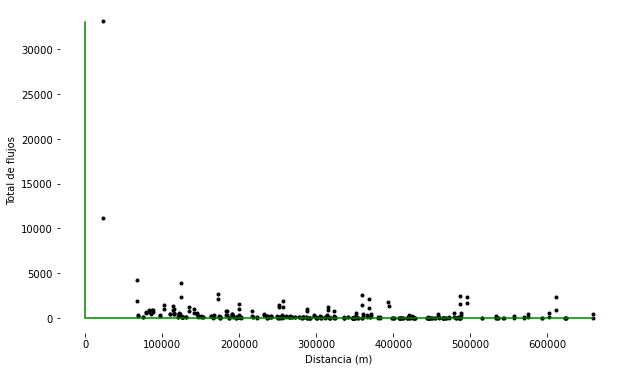

In [125]:
# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(10,6))

# plot de los puntos
ax.scatter(datos_diadas['dist'], datos_diadas['personas_mig'], marker='.', color='k')

# crea la linea de ejes
xvals = np.geomspace(0.0055, datos_diadas['dist'].max(), 1000)
yvals = np.power(xvals,-2.0)

# la agrega al plot
ax.plot(xvals, yvals, color='g')

# hide spines
[ax.spines[i].set_visible(False) for i in ['right', 'top', 'left', 'bottom']]

# etiquetas
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Distancia (m)")

# se ven dos outlyers claramente, deben ser Mvdeo y Canelones.

Text(0.5, 0, 'Distancia (m)')

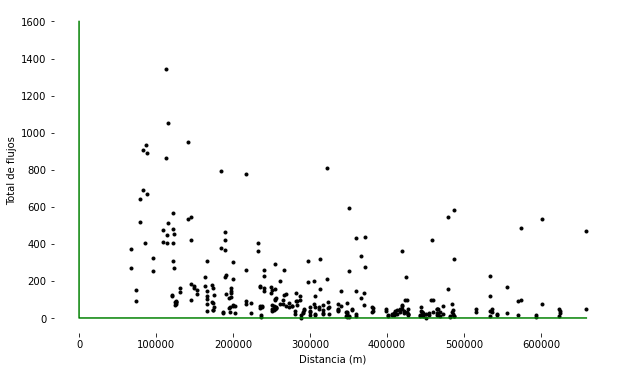

In [126]:
# mismo gráfico sin Mvdeo.
sin_mvo = datos_diadas[(datos_diadas['depto_origen'] > 1) & (datos_diadas['depto_destino'] > 1)]

# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(10,6))

# plot de los puntos
ax.scatter(sin_mvo['dist'], sin_mvo['personas_mig'], marker='.', color='k')

# crea la linea de ejes
xvals = np.geomspace(0.025, sin_mvo['dist'].max(), 100)
yvals = np.power(xvals,-2.0)

# la agrega al plot
ax.plot(xvals, yvals, color='g')

# hide spines
[ax.spines[i].set_visible(False) for i in ['right', 'top', 'left', 'bottom']]

# Etiquetas
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Distancia (m)")

Text(0.5, 0, 'Población en origen')

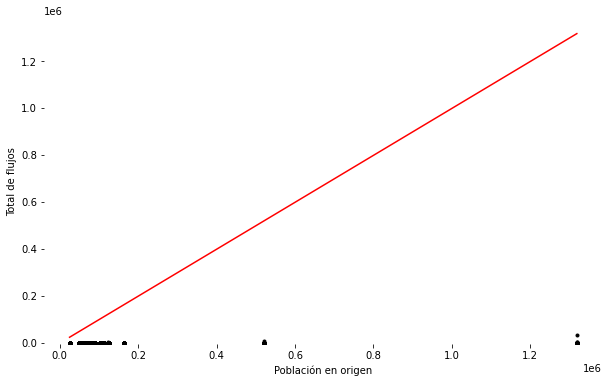

In [127]:
# gráfico de flujos contra población en el origen
f, ax = plt.subplots(1, figsize=(10,6))

# Plot data points
ax.scatter(datos_diadas['pob_origen'], datos_diadas['personas_mig'], marker='.', color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(datos_diadas['pob_origen'].min(), datos_diadas['pob_origen'].max(), 100)
yvals = np.power(xvals, 1.0)

# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-5000, datos_diadas['pob_origen'].max()*1.05)

# hide spines
[ax.spines[i].set_visible(False) for i in ['right', 'top', 'left', 'bottom']]

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Población en origen")

Text(0.5, 0, 'Población en origen')

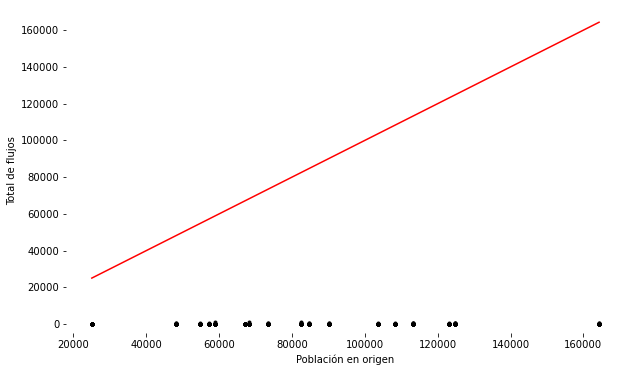

In [128]:
# gráfico de flujos contra población en el origen
f, ax = plt.subplots(1, figsize=(10,6))

sin_mvo_can = sin_mvo.loc[(sin_mvo.depto_origen!=3) & (sin_mvo.depto_destino!=3)]

# Plot data points
ax.scatter(sin_mvo_can['pob_origen'], sin_mvo_can['personas_mig'], marker='.', color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(sin_mvo_can['pob_origen'].min(), sin_mvo_can['pob_origen'].max(), 100)
yvals = np.power(xvals, 1.0)

# Now add function line to plot
ax.plot(xvals, yvals, color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-5000, sin_mvo_can['pob_origen'].max()*1.05)

# hide spines
[ax.spines[i].set_visible(False) for i in ['right', 'top', 'left', 'bottom']]

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Población en origen")

Text(0.5, 0, 'PBI en destino')

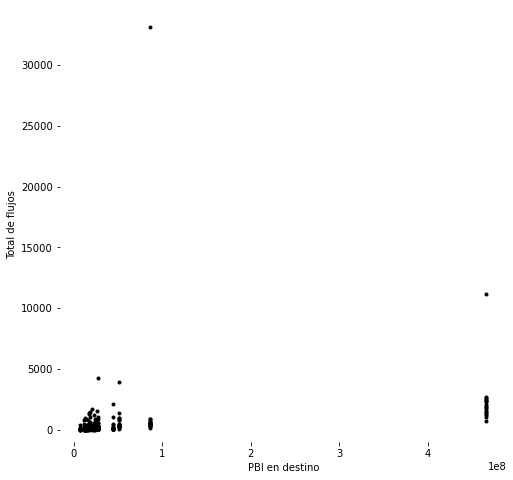

In [129]:
# Plot de PBI en destino contra personas migrantes
f, ax = plt.subplots(1,figsize=(8,8))

# Plot data points
ax.scatter(datos_diadas['pbi_destino'], datos_diadas['personas_mig'], marker='.',color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(datos_diadas['pbi_destino'].min(), datos_diadas['pbi_destino'].max(), 100)
yvals = np.power(xvals,1.0)

# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-1000, datos_diadas['personas_mig'].max()*1.05)

# hide spines
[ax.spines[i].set_visible(False) for i in ['right', 'top', 'left', 'bottom']]

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("PBI en destino")

# Modelo restringido en origen

1 $$T_{ij} = A_{i}O_{i}W_{j}^{\alpha}d_{ij}^{-\beta}$$

dónde

2 $$O_{i} = \sum_{j}T_{ij}$$


3 $$A_{i} = \frac{1}{\sum_{j}W_{j}^{\alpha}d_{ij}^{-\beta}}$$



En el modelo restringido en origen $O_{i}$ no tiene parámetro dado que representa valores conocidos. $A_{i}$ es un factor de balance que refiere a cada origen $i$. Más específicamente $A_{i}$ permite que la suma de los valores estimados sea igual al total conocido $O_{i}$

El modelo es re-especificado como un modelo de regresión de Poisson. Se asume una vinculación

**We set about re-specifying the Production-Constrained model as a Poisson regression model in a similar way to how we did before. We need to take logs of the right-hand side of equation and assume that these are logarithmially linked to the Poisson distributed mean ($\lambda_{ij}$) of the $T_{ij}$ variable. Equation 1 (above) then becomes:**


4   $$ \lambda_{ij} = \exp( \mu_{i} + \alpha \ln W_{j} - \beta \ln d_{ij} )$$



In [130]:
# el depto_origen se cambio a tipo texto para que no sea tomada como variable numérica por la regresión
#  datos_diadas['depto_origen'] = datos_diadas.depto_origen.astype(str)

# respalda el objeto para usarlo en el otro modelo
dd=datos_diadas

In [131]:
datos_diadas.head()

,cod,depto_origen,nom_depto_orig,depto_destino,nom_depto_des,personas_mig,pbi_origen,pob_origen,pbi_destino,pob_destino,dist,log_pbi_destino,log_dist
0,102,1,MONTEVIDEO,2,ARTIGAS,914,465848031,1318755,14214980,73377,610726,16.469807,13.322404
1,302,3,CANELONES,2,ARTIGAS,74,86306492,520173,14214980,73377,601915,16.469807,13.307872
2,402,4,CERRO LARGO,2,ARTIGAS,15,17048887,84698,14214980,73377,406694,16.469807,12.915816
3,502,5,COLONIA,2,ARTIGAS,28,43788749,123203,14214980,73377,556292,16.469807,13.229049
4,602,6,DURAZNO,2,ARTIGAS,32,13023942,57084,14214980,73377,446123,16.469807,13.008350


Resultados de la aplicación del modelo restringido en origen:

In [132]:
# Here we specify a model with no intercept (given by the -1 in the formula)
# In practice this means that all AiOis are estimated against an intercept of zero.
# Including the interval would mean setting the first borough in OrigNewCode to the intercept
# and interpreting all other categories in relation to that, which is less useful but would still work.
formula = "personas_mig ~ nom_depto_orig + log_pbi_destino + log_dist -1"
prodSim = smf.glm(formula=formula, data = datos_diadas, family = sm.families.Poisson()).fit()
prodSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      321
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14973.
Date:                Fri, 18 Dec 2020   Deviance:                       27718.
Time:                        19:46:20   Pearson chi2:                 3.00e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
nom_depto_orig[ARTIGAS]            0.8906      0.075     11.948      0.000       0.745       1.037
nom_depto_orig[CANELONES]          0.3788      0.069      5.491      0.000       0.244       0.514
nom_depto_orig[CERRO LARGO]        0.5190      0.074      6.988      0.000       0.373       0.665
nom_depto_orig[COLONIA]            0.1648      0.073      2.255      0.024       0.022       0.308
nom_depto_orig[DURAZNO]           -0.0837      0.073     -1.140      0.254      -0.227       0.060
nom_depto_orig[FLORES]            -1.0428      0.075    -13.842      0.000      -1.190      -0.895
nom_depto_orig[FLORIDA]           -0.3389      0.073     -4.672      0.000      -0.481      -0.197
nom_depto_orig[LAVALLEJA]         -0.3429      0.073     -4.688      0.000      -0.486      -0.200
nom_depto_orig[MALDONADO]          0.2271      0.073      3.128      0.002       0.085       0.369
nom_depto_orig[MONTEVIDEO]         2.5748      0.067     38.545      0.000       2.444       2.706
nom_depto_orig[PAYSANDU]           0.5033      0.073      6.882      0.000       0.360       0.647
nom_depto_orig[RIO NEGRO]         -0.0120      0.073     -0.164      0.870      -0.156       0.132
nom_depto_orig[RIVERA]             0.7054      0.074      9.489      0.000       0.560       0.851
nom_depto_orig[ROCHA]              0.0459      0.074      0.618      0.537      -0.100       0.192
nom_depto_orig[SALTO]              0.7632      0.074     10.334      0.000       0.618       0.908
nom_depto_orig[SAN JOSE]          -0.4887      0.072     -6.775      0.000      -0.630      -0.347
nom_depto_orig[SORIANO]            0.2470      0.073      3.389      0.001       0.104       0.390
nom_depto_orig[TACUAREMBO]         0.6533      0.074      8.878      0.000       0.509       0.798
nom_depto_orig[TREINTA Y TRES]    -0.0210      0.074     -0.283      0.777      -0.167       0.125
log_pbi_destino                    0.8527      0.002    355.615      0.000       0.848       0.857
log_dist                          -0.7834      0.003   -224.855      0.000      -0.790      -0.777
==================================================================================================
"""

In [133]:
prodSim_latex = prodSim.summary().as_latex()
f = open("tablas/prodSim.tex", "w")
f.write(prodSim_latex)
f.close()

De los resultados se desprende un parámetro $\alpha$ relacionado a la actractividad del destino de 0,8527.

El parámetro $\beta$ relativo al decaimiento por la distancia es de -0,7830

El coeficiente para cada origen es el valor registrado $A_{i}O_{i}$ para ese origen.

## Estimaciones del modelo restringido en origen

Los parámetros calculados se insertan en la ecuación nro. 4.

$$ \lambda_{ij} = \exp( \mu_{i} + 0,8527 ln W_{j}  + 0,7830 ln d_{ij} )$$


In [134]:
# create some Oi and Dj columns in the dataframe and store row and column totals in them:
# First get the origin sums and rename the column created
O_i = datos_diadas.groupby('depto_origen')['personas_mig'].sum().to_frame()
O_i.rename(columns = {'personas_mig':'O_i'}, inplace=True)

# Now get the destination sums
D_j = datos_diadas.groupby('depto_destino')['personas_mig'].sum().to_frame()
D_j.rename(columns = {'personas_mig':'D_j'}, inplace=True)

# Merge in O_i
datos_diadas = datos_diadas.merge(O_i,left_on='depto_origen', right_index=True)

# Merge in D_j
datos_diadas = datos_diadas.merge(D_j,left_on='depto_destino', right_index=True)

datos_diadas.head()

,cod,depto_origen,nom_depto_orig,depto_destino,nom_depto_des,personas_mig,pbi_origen,pob_origen,pbi_destino,pob_destino,dist,log_pbi_destino,log_dist,O_i,D_j
0,102,1,MONTEVIDEO,2,ARTIGAS,914,465848031,1318755,14214980,73377,610726,16.469807,13.322404,58655,1810
1,302,3,CANELONES,2,ARTIGAS,74,86306492,520173,14214980,73377,601915,16.469807,13.307872,17233,1810
2,402,4,CERRO LARGO,2,ARTIGAS,15,17048887,84698,14214980,73377,406694,16.469807,12.915816,4459,1810
3,502,5,COLONIA,2,ARTIGAS,28,43788749,123203,14214980,73377,556292,16.469807,13.229049,4752,1810
4,602,6,DURAZNO,2,ARTIGAS,32,13023942,57084,14214980,73377,446123,16.469807,13.008350,3757,1810


In [135]:
# recupera los parámetros del modelo
mu_i = prodSim.params.to_frame()

# elimina caractérres no numéricos para poder mergear
mu_i.rename(index = dict(zip(mu_i.index[0:-2].values, mu_i.index[0:-2].str.replace(r'[^ ABCDEFGHIJKLMNÑOPQRSTUVWXYZ]','').values)),
            inplace=True)

# renombre columna
mu_i.rename(columns = {0:'mu_i'}, inplace=True)

# merge
datos_diadas = datos_diadas.merge(mu_i, left_on='nom_depto_orig', right_index=True)

In [136]:
mu_i

,mu_i
ARTIGAS,0.890649
CANELONES,0.378819
CERRO LARGO,0.518985
COLONIA,0.164846
DURAZNO,-0.083656
FLORES,-1.042821
FLORIDA,-0.338866
LAVALLEJA,-0.342917
MALDONADO,0.227074
MONTEVIDEO,2.574775


In [137]:
# guarda parámetros estimados en objetos
alpha = prodSim.params[19]
beta  = prodSim.params[20]

print("alfa (log PBI destino)= " + str(alpha))
print("beta (log distancia)= " + str(beta))

alfa (log PBI destino)= 0.8527323709463686
beta (log distancia)= -0.783423211608453


In [138]:
# genera estimación redondeada
# esta es la estimación del modelo de la ecuación 4, imputando los parámetro alfa y beta calculados
datos_diadas['prodsimest'] = np.round(np.exp(datos_diadas['mu_i']
                                             + alpha * datos_diadas['log_pbi_destino']
                                             + beta * datos_diadas['log_dist']))

In [139]:
# matriz de flujos estimada por el modelo
datos_diadas['depto_origen'] = datos_diadas.depto_origen.astype(int)

matrix_prodsim = pd.pivot_table(datos_diadas,
                                values='prodsimest',
                                index ='depto_origen',
                                columns='depto_destino',
                                fill_value=0,
                                aggfunc=sum,
                                margins=True,
                                margins_name='Total')

matrix_prodsim.Total = matrix_prodsim.Total.astype(int)

matrix_prodsim

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Total
depto_origen,,,,,,,,,,,,,,,,,,,,
1,0,484,29872,797,3397,1081,705,2378,1714,5034,1237,1285,769,1159,953,4712,1438,900,739,58654
2,1761,0,423,144,252,107,64,121,99,253,266,206,337,106,378,163,173,219,92,5164
3,14004,54,0,93,351,125,81,297,216,602,140,144,87,137,107,445,161,102,88,17234
4,1713,85,426,0,198,107,54,120,128,305,137,117,173,147,135,144,115,153,202,4459
5,2291,47,505,62,0,97,85,129,86,229,150,184,70,73,106,263,242,83,50,4752
6,1601,43,394,74,212,0,100,145,87,197,115,113,73,71,87,156,125,100,65,3758
7,657,16,162,24,117,63,0,54,30,73,56,57,27,24,37,80,67,35,20,1599
8,2092,29,557,49,168,86,51,0,95,217,77,74,48,63,57,192,80,59,47,4041
9,1679,27,451,58,125,58,31,106,0,362,60,57,44,93,47,120,61,49,62,3490


In [140]:
matrix

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Total
depto_origen,,,,,,,,,,,,,,,,,,,,
Mvdeo.,0,914,33127,1387,2100,982,378,1026,825,3914,1075,886,1665,1266,1547,4209,1173,1421,760,58655
Artigas,2395,0,536,20,167,33,21,40,15,472,200,57,146,47,794,92,24,100,5,5164
Can.,11162,74,0,274,422,223,82,670,403,1345,148,154,320,360,159,908,154,251,124,17233
C. Largo,1805,15,435,0,63,67,5,73,131,810,61,41,145,95,19,49,34,135,476,4459
Colonia,2690,28,366,20,0,63,69,53,19,309,71,88,34,35,68,269,513,34,23,4752
Durazno,1610,32,466,64,70,0,149,404,67,198,59,62,42,61,28,124,32,212,77,3757
Flores,735,2,162,13,86,90,0,76,5,79,30,36,10,13,17,116,85,29,14,1598
Florida,1420,13,892,37,107,307,84,0,163,310,47,30,46,62,19,321,51,68,64,4041
Lavalleja,1264,7,446,64,39,29,17,138,0,936,28,11,25,150,15,45,11,45,221,3491


In [141]:
matrix_prodsim_tex = matrix_prodsim.rename(index=dict(zip(coddep, nomdep)))

matrix_prodsim_tex.to_latex(buf= "tablas/prodsim_matriz_orig_dest.tex", bold_rows=False,
                            column_format = colformato,  float_format="%.2f",
                            caption= 'Matriz de movimientos entre departamentos estimada mediante SIM restringido en origen.')

Se puede identificar la coincidencia de la matriz de los datos originales con la de los datos estimados en la columna de origen $O_{i}$, con leves diferencias producto del redondeo.

$$\sum_{j}T_{ij} = \sum_{j}\lambda_{ij} = O_{i}$$

In [142]:
# bondad de ajuste

# función para calcular el R cuadrado
def calcR2(obs, est):
    return np.power(np.corrcoef(obs,est), 2.0)[0][1]

# función para calcular el error medio cuadrático
def calcRMSE(obs,est):
    return np.sqrt((np.power((obs - est), 2.0)).mean())

In [143]:
printmd('**Bondad de ajuste del modelo restringido en origen**')

printmd("$R²$ = " + round(calcR2(datos_diadas['personas_mig'], datos_diadas['prodsimest']), 4).astype(str))

printmd("RMSE = " + round(calcRMSE(datos_diadas['personas_mig'], datos_diadas['prodsimest']), 4).astype(str))


**Bondad de ajuste del modelo restringido en origen**

$R²$ = 0.9738

RMSE = 322.431

# Modelo de doble restricción

5    $$ T_{ij} = A_{i}O_{i}B_{i}D_{j}d_{ij}^{-\beta }$$

dónde

6 $$O_{i} = \sum_{j}T_{ij}$$

7 $$D_{j} = \sum_{i}T_{ij}$$

8 $$A_{i} = \frac{1}{\sum_{j}B_{j}D_{j}d_{ij}^{-\beta}}$$

9 $$B_{j} = \frac{1}{\sum_{j}A_{i}O_{j}d_{ij}^{-\beta}}$$

La dificultad es que $A_{i}$ depende de $B_{j}$ y viceversa. Pero se puede arribar a un valor para ambos factores fijando el valor de $B$ inicialmente como 1, y luego iterando refinando el valor de cada uno hasta que sea estable (converjan).

In [144]:
# Modelo de restricción doble

# recupera los datos del respaldo
datos_diadas = dd
# formula = "personas_mig ~ nom_depto_orig + nom_depto_des + log_pbi_destino + log_dist -1"

# siguiendo a Dennett y la guía de R, cambiamos la fórmula, borrando el "-1" al final
# es decir que se mantiene la intersección

# The code below has changed a litte from the singly constrained models I have removed the ‘-1’
# which means that an intercept will appear in the model again. This is not because I want an
# intercept as it makes the origin and destination coefficients harder to interpret - reference categories
# zones will appear and the coefficients will need to be compared with the intercept - rather the ‘-1’ cheat
# for removing the intercept only works with one factor level - here we have two (origins and destinations).
# For full details and an explanation for alternative ways for dealing with this, please visit
# here - https://stats.stackexchange.com/questions/215779/removing-intercept-from-glm-for-multiple-factorial-predictors-only-works-for-fir - for ease, here we will just continue with the intercept.

formula = "personas_mig ~ nom_depto_orig + nom_depto_des + log_pbi_destino + log_dist"

doubSim = smf.glm(formula=formula, data = datos_diadas, family = sm.families.Poisson()).fit()
doubSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      304
Model Family:                 Poisson   Df Model:                           37
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12551.
Date:                Fri, 18 Dec 2020   Deviance:                       22874.
Time:                        19:46:21   Pearson chi2:                 2.48e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.0557      0.018      3.137      0.002       0.021       0.091
nom_depto_orig[T.CANELONES]         -0.2652      0.019    -13.633      0.000      -0.303      -0.227
nom_depto_orig[T.CERRO LARGO]       -0.3530      0.021    -17.210      0.000      -0.393      -0.313
nom_depto_orig[T.COLONIA]           -0.6452      0.020    -31.665      0.000      -0.685      -0.605
nom_depto_orig[T.DURAZNO]           -0.8956      0.022    -41.301      0.000      -0.938      -0.853
nom_depto_orig[T.FLORES]            -1.8378      0.029    -63.650      0.000      -1.894      -1.781
nom_depto_orig[T.FLORIDA]           -1.1349      0.022    -52.545      0.000      -1.177      -1.093
nom_depto_orig[T.LAVALLEJA]         -1.1729      0.022    -52.395      0.000      -1.217      -1.129
nom_depto_orig[T.MALDONADO]         -0.5582      0.020    -28.488      0.000      -0.597      -0.520
nom_depto_orig[T.MONTEVIDEO]         1.7104      0.017    103.476      0.000       1.678       1.743
nom_depto_orig[T.PAYSANDU]          -0.3186      0.020    -16.024      0.000      -0.358      -0.280
nom_depto_orig[T.RIO NEGRO]         -0.8202      0.022    -36.774      0.000      -0.864      -0.776
nom_depto_orig[T.RIVERA]            -0.1702      0.020     -8.456      0.000      -0.210      -0.131
nom_depto_orig[T.ROCHA]             -0.8116      0.022    -36.687      0.000      -0.855      -0.768
nom_depto_orig[T.SALTO]             -0.0802      0.020     -4.090      0.000      -0.119      -0.042
nom_depto_orig[T.SAN JOSE]          -1.2430      0.022    -57.139      0.000      -1.286      -1.200
nom_depto_orig[T.SORIANO]           -0.5496      0.020    -27.059      0.000      -0.589      -0.510
nom_depto_orig[T.TACUAREMBO]        -0.1954      0.019    -10.085      0.000      -0.233      -0.157
nom_depto_orig[T.TREINTA Y TRES]    -0.8797      0.023    -38.760      0.000      -0.924      -0.835
nom_depto_des[T.CANELONES]           0.2298      0.029      7.999      0.000       0.173       0.286
nom_depto_des[T.CERRO LARGO]         0.1919      0.030      6.419      0.000       0.133       0.250
nom_depto_des[T.COLONIA]            -0.3190      0.028    -11.346      0.000      -0.374      -0.264
nom_depto_des[T.DURAZNO]            -0.0632      0.031     -2.056      0.040      -0.123      -0.003
nom_depto_des[T.FLORES]             -0.3382      0.036     -9.372      0.000      -0.409      -0.267
nom_depto_des[T.FLORIDA]            -0.3175      0.030    -10.708      0.000      -0.376      -0.259
nom_depto_des[T.LAVALLEJA]          -0.3194      0.031    -10.351      0.000      -0.380      -0.259
nom_depto_des[T.MALDONADO]           0.2724      0.027     10.262      0.000       0.220       0.324
nom_depto_des[T.MONTEVIDEO]         -0.0855      0.03

In [145]:
# guarda DF para enviar a Eugenia
datos_diadas.head()
datos_diadas.to_csv('tablas/datos_diadas.csv', index=False)

In [146]:
doubSim_latex = doubSim.summary().as_latex()
f = open("tablas/doubSim.tex", "w")
f.write(doubSim_latex)
f.close()

In [147]:
# recupera los valores estimados
datos_diadas['doubsim_ajustado'] = np.round(doubSim.predict())

datos_diadas['depto_origen'] = datos_diadas.depto_origen.astype(int)

# matriz de los valores estimados
matrix_doubsim = pd.pivot_table(datos_diadas,
                                values='doubsim_ajustado',
                                index ='depto_origen',
                                columns='depto_destino',
                                fill_value=0,
                                aggfunc=sum,
                                margins=True,
                                margins_name='Total')

matrix_doubsim.Total = matrix_doubsim.Total.astype(int)

matrix_doubsim

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Total
depto_origen,,,,,,,,,,,,,,,,,,,,
1,0,518,31740,1002,2410,1005,496,1633,1199,6301,1091,899,957,1265,1118,4018,1029,1137,839,58657
2,1665,0,551,177,189,102,47,91,75,346,226,142,378,120,404,158,125,263,105,5164
3,13455,73,0,145,312,144,71,251,186,933,154,125,134,186,157,480,143,161,123,17233
4,1600,88,546,0,149,101,40,89,93,405,121,84,204,159,156,138,85,188,213,4459
5,2150,52,658,83,0,95,61,98,67,321,136,131,92,87,129,247,173,110,62,4752
6,1514,48,512,95,160,0,69,106,66,274,104,82,93,83,105,150,92,128,76,3757
7,628,19,212,32,87,58,0,41,23,104,51,41,35,29,45,76,49,46,24,1600
8,1919,33,697,65,128,83,38,0,71,297,71,55,63,73,71,180,61,78,56,4039
9,1517,30,556,74,95,55,23,76,0,457,55,42,56,101,58,114,46,64,70,3489


In [148]:
matrix_doubsim_tex = matrix_doubsim.rename(index=dict(zip(coddep, nomdep)))

matrix_doubsim_tex.to_latex(buf = "tablas/doubsim_matriz_orig_dest.tex",
                            bold_rows = False,
                            column_format = colformato,
                            float_format ="%.2f",
                            caption = 'Matriz de movimientos entre departamentos estimada mediante SIM de doble restricción.')

In [149]:
matrix

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Total
depto_origen,,,,,,,,,,,,,,,,,,,,
Mvdeo.,0,914,33127,1387,2100,982,378,1026,825,3914,1075,886,1665,1266,1547,4209,1173,1421,760,58655
Artigas,2395,0,536,20,167,33,21,40,15,472,200,57,146,47,794,92,24,100,5,5164
Can.,11162,74,0,274,422,223,82,670,403,1345,148,154,320,360,159,908,154,251,124,17233
C. Largo,1805,15,435,0,63,67,5,73,131,810,61,41,145,95,19,49,34,135,476,4459
Colonia,2690,28,366,20,0,63,69,53,19,309,71,88,34,35,68,269,513,34,23,4752
Durazno,1610,32,466,64,70,0,149,404,67,198,59,62,42,61,28,124,32,212,77,3757
Flores,735,2,162,13,86,90,0,76,5,79,30,36,10,13,17,116,85,29,14,1598
Florida,1420,13,892,37,107,307,84,0,163,310,47,30,46,62,19,321,51,68,64,4041
Lavalleja,1264,7,446,64,39,29,17,138,0,936,28,11,25,150,15,45,11,45,221,3491


Se puede observar la igualdad de los valores originales $O_{i}$ y $D_{j}$, pero al igual que en el modelo de restricción en origen se producen leves direrencias que atrubuimos al redondeo.

In [150]:
printmd('**Bondad de ajuste del modelo de doble restricción**')

printmd("$R²$ = " + round(calcR2(datos_diadas['personas_mig'],  datos_diadas['doubsim_ajustado']), 4).astype(str))

printmd("RMSE = " + round(calcRMSE(datos_diadas['personas_mig'],datos_diadas['doubsim_ajustado']), 4).astype(str))

**Bondad de ajuste del modelo de doble restricción**

$R²$ = 0.9827

RMSE = 256.3925

El coeficiente de determinación $R²$ mejora en comparación con resultante del modelo restringido en origen.

In a departure from Dennett, I've rewritten the algorithm as a function, which can then be called subject to the required parameters. In order for it to work it requires the following things:

    pd - a pandas dataframe of origin-destination pairwise flows and associated data.
    orig_field - the name of the dataframe field in pd that uniquely labels origin zones.
    dest_field - the name of the dataframe field in pd that uniquely labels destination zones.
    Oi_field - the name of the dataframe field that stores total flows from a given origin $i$
    Dj_field - the name of the dataframe field that stores total flows to a given destination $j$
    cij_field - the name of the dataframe field that stores the pairwise cost (e.g. distance) between $i$ and $j$
    beta - a constant for the beta parameter you wish to use in the model
    cost_function - a string representing the cost function, either 'power' or 'exponential'
    Ainame - What you want to call the new field in pd that will hold $A&lt;/em&gt;{i}$ values, defaults to "Ai_new"
    Bjname - What you want to call the new field in pd that will hold $B&lt;/em&gt;{j}$ values, defaults to "Bj_new"
    converge - A threshold value at which a model can be said to have converged, the default of 0.001 seems to work fine.

NB Remember that we calculated $O_{i}$ and $D_{j}$ earlier, they are simply the total flows by either origin or destination.

In [151]:
datos_diadas.head()

,cod,depto_origen,nom_depto_orig,depto_destino,nom_depto_des,personas_mig,pbi_origen,pob_origen,pbi_destino,pob_destino,dist,log_pbi_destino,log_dist,doubsim_ajustado
0,102,1,MONTEVIDEO,2,ARTIGAS,914,465848031,1318755,14214980,73377,610726,16.469807,13.322404,518.0
1,302,3,CANELONES,2,ARTIGAS,74,86306492,520173,14214980,73377,601915,16.469807,13.307872,73.0
2,402,4,CERRO LARGO,2,ARTIGAS,15,17048887,84698,14214980,73377,406694,16.469807,12.915816,88.0
3,502,5,COLONIA,2,ARTIGAS,28,43788749,123203,14214980,73377,556292,16.469807,13.229049,52.0
4,602,6,DURAZNO,2,ARTIGAS,32,13023942,57084,14214980,73377,446123,16.469807,13.008350,48.0


In [152]:
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field,
                               Oi_field, Dj_field, cij_field, beta, 
                               cost_function,
                               Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]
    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

In [153]:
# create some Oi and Dj columns in the dataframe and store row and column totals in them:
# First get the origin sums and rename the column created
O_i = datos_diadas.groupby('depto_origen')['personas_mig'].sum().to_frame()
O_i.rename(columns = {'personas_mig':'O_i'}, inplace=True)

# Now get the destination sums
D_j = datos_diadas.groupby('depto_destino')['personas_mig'].sum().to_frame()
D_j.rename(columns = {'personas_mig':'D_j'}, inplace=True)

# Merge in O_i
datos_diadas = datos_diadas.merge(O_i,left_on='depto_origen', right_index=True)

# Merge in D_j
datos_diadas = datos_diadas.merge(D_j,left_on='depto_destino', right_index=True)

datos_diadas.head()

,cod,depto_origen,nom_depto_orig,depto_destino,nom_depto_des,personas_mig,pbi_origen,pob_origen,pbi_destino,pob_destino,dist,log_pbi_destino,log_dist,doubsim_ajustado,O_i,D_j
0,102,1,MONTEVIDEO,2,ARTIGAS,914,465848031,1318755,14214980,73377,610726,16.469807,13.322404,518.0,58655,1810
1,302,3,CANELONES,2,ARTIGAS,74,86306492,520173,14214980,73377,601915,16.469807,13.307872,73.0,17233,1810
2,402,4,CERRO LARGO,2,ARTIGAS,15,17048887,84698,14214980,73377,406694,16.469807,12.915816,88.0,4459,1810
3,502,5,COLONIA,2,ARTIGAS,28,43788749,123203,14214980,73377,556292,16.469807,13.229049,52.0,4752,1810
4,602,6,DURAZNO,2,ARTIGAS,32,13023942,57084,14214980,73377,446123,16.469807,13.008350,48.0,3757,1810


In [154]:
# recupera el beta del logaritmo de la distancia del modelo anterior
beta = doubSim.params[-1]
beta

-0.7134885292653625

In [155]:
# recupera factores de balance
datos_diadas = balance_doubly_constrained(datos_diadas, 'nom_depto_orig', 'nom_depto_des',
                                          'O_i', 'D_j', 'log_dist', beta, 'pow',
                                          Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


In [156]:
datos_diadas.head()

,cod,depto_origen,nom_depto_orig,depto_destino,nom_depto_des,personas_mig,pbi_origen,pob_origen,pbi_destino,pob_destino,dist,log_pbi_destino,log_dist,doubsim_ajustado,O_i,D_j,Ai_new,Bj_new
0,102,1,MONTEVIDEO,2,ARTIGAS,914,465848031,1318755,14214980,73377,610726,16.469807,13.322404,518.0,58655,1810,0.000062,0.896051
1,302,3,CANELONES,2,ARTIGAS,74,86306492,520173,14214980,73377,601915,16.469807,13.307872,73.0,17233,1810,0.000044,0.896051
2,402,4,CERRO LARGO,2,ARTIGAS,15,17048887,84698,14214980,73377,406694,16.469807,12.915816,88.0,4459,1810,0.000039,0.896051
3,502,5,COLONIA,2,ARTIGAS,28,43788749,123203,14214980,73377,556292,16.469807,13.229049,52.0,4752,1810,0.000038,0.896051
4,602,6,DURAZNO,2,ARTIGAS,32,13023942,57084,14214980,73377,446123,16.469807,13.008350,48.0,3757,1810,0.000038,0.896051


In [157]:
# Now predict the model again using the new Ai and Dj fields.
datos_diadas['SIM_est_pow'] = np.round(datos_diadas['O_i'] * datos_diadas['Ai_new'] * datos_diadas['D_j'] * datos_diadas['Bj_new'] * 
                                       np.exp(np.log(datos_diadas['log_dist'])*beta))


In [158]:
# Check out the matrix
pd.pivot_table(datos_diadas, values='SIM_est_pow', index ='depto_origen',
               columns='depto_destino', fill_value=0, aggfunc=sum, margins=True)

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,All
depto_origen,,,,,,,,,,,,,,,,,,,,
1,0,930,24855,1544,2855,1326,668,1721,1345,6569,1846,1483,1682,1605,1977,3716,1490,1834,1207,58653.0
2,2241,0,1148,87,151,72,36,88,70,338,105,83,101,86,118,185,82,106,66,5163.0
3,10155,195,0,324,594,278,140,363,284,1382,387,310,352,337,414,767,312,384,254,17232.0
4,1953,46,1003,0,130,63,31,77,62,299,88,70,84,77,96,160,69,90,61,4459.0
5,2135,47,1087,77,0,67,34,83,65,313,95,77,85,78,101,180,78,92,59,4753.0
6,1650,37,847,62,111,0,28,67,51,246,74,59,67,62,79,137,59,74,48,3758.0
7,697,16,358,26,48,23,0,28,21,103,32,25,28,26,33,59,26,31,20,1600.0
8,1799,38,930,64,116,56,28,0,55,264,76,61,70,66,82,149,61,76,50,4041.0
9,1541,33,797,56,99,47,23,60,0,240,65,52,60,59,70,125,52,65,45,3489.0


In [159]:
printmd('**Bondad de ajuste del modelo de doble restricción**')

printmd("$R²$ = " + round(calcR2(datos_diadas['personas_mig'],  datos_diadas['doubsim_ajustado']), 4).astype(str))

printmd("RMSE = " + round(calcRMSE(datos_diadas['personas_mig'],datos_diadas['doubsim_ajustado']), 4).astype(str))

**Bondad de ajuste del modelo de doble restricción**

$R²$ = 0.9827

RMSE = 256.3925

In [160]:
# jugar con modelación de distance decay
# jugar con distancia en lugar de logaritmo
# probar con algún modelo kitchen sink
# graficas y algún mapa
#!jupyter nbconvert --to markdown --no-input 02-metodologia.ipynb 

# probar paquete SPInt taylor oshan

# ATENCIÓN!
# Another thing to note is that the example we used here had quite neat data. You will almost certainly run into problems if you have sparse data or predictors with 0s in them. If this happens, then you might need to either drop some rows in your data (if populated with 0s) or substitute 0s for very small numbers, much less than 1, but greater than 0 (this is because you can’t take the log of 0). Taylor Oshan's SpInt implementation in Python uses a special Poisson regression approach that better handles sparse data structures.


# modelar con binomial negativa

